In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Part 1: Price Prediction

In [11]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [12]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [13]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [14]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [15]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [16]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1239, 20, 1) Y.shape (1239, 1)


In [4]:
### try autoregressive RNN model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    out, _ = self.rnn(X, (h0, c0))

    # we only want h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [3]:
model = RNN(1, 5, 1, 1)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# model.to(device)

cuda:0


In [20]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [6]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses

In [22]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [23]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [24]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.4164, Test Loss: 2.2982
Epoch 10/200, Train Loss: 0.2037, Test Loss: 0.2521
Epoch 15/200, Train Loss: 0.0859, Test Loss: 0.6055
Epoch 20/200, Train Loss: 0.0163, Test Loss: 0.1434
Epoch 25/200, Train Loss: 0.0158, Test Loss: 0.1056
Epoch 30/200, Train Loss: 0.0169, Test Loss: 0.1386
Epoch 35/200, Train Loss: 0.0124, Test Loss: 0.0352
Epoch 40/200, Train Loss: 0.0082, Test Loss: 0.0504
Epoch 45/200, Train Loss: 0.0063, Test Loss: 0.0230
Epoch 50/200, Train Loss: 0.0060, Test Loss: 0.0301
Epoch 55/200, Train Loss: 0.0059, Test Loss: 0.0223
Epoch 60/200, Train Loss: 0.0060, Test Loss: 0.0235
Epoch 65/200, Train Loss: 0.0059, Test Loss: 0.0332
Epoch 70/200, Train Loss: 0.0057, Test Loss: 0.0227
Epoch 75/200, Train Loss: 0.0056, Test Loss: 0.0274
Epoch 80/200, Train Loss: 0.0055, Test Loss: 0.0232
Epoch 85/200, Train Loss: 0.0055, Test Loss: 0.0253
Epoch 90/200, Train Loss: 0.0054, Test Loss: 0.0240
Epoch 95/200, Train Loss: 0.0054, Test Loss: 0.0255
Epoch 100/200

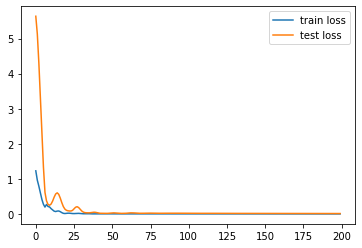

In [25]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [26]:
# One-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1, T, 1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

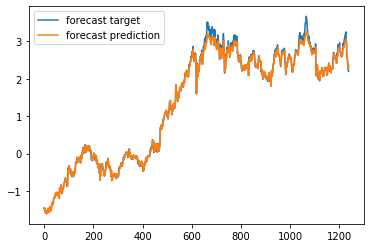

In [27]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [28]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

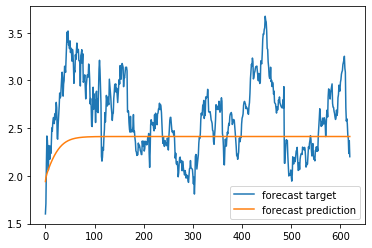

In [29]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# Part 2: Returns

In [30]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [31]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [32]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [33]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


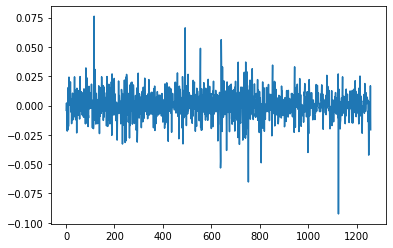

In [34]:
plt.plot(df['Return']);

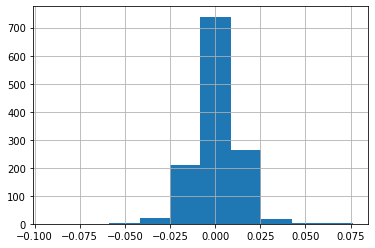

In [35]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [36]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [37]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [38]:
### try autoregressive RNN model
model = RNN(1, 5, 1, 1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [39]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [40]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [41]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [42]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 1.0700, Test Loss: 1.0729
Epoch 10/200, Train Loss: 1.0507, Test Loss: 1.0783
Epoch 15/200, Train Loss: 1.0535, Test Loss: 1.0857
Epoch 20/200, Train Loss: 1.0483, Test Loss: 1.0753
Epoch 25/200, Train Loss: 1.0467, Test Loss: 1.0705
Epoch 30/200, Train Loss: 1.0455, Test Loss: 1.0712
Epoch 35/200, Train Loss: 1.0430, Test Loss: 1.0757
Epoch 40/200, Train Loss: 1.0417, Test Loss: 1.0816
Epoch 45/200, Train Loss: 1.0407, Test Loss: 1.0835
Epoch 50/200, Train Loss: 1.0393, Test Loss: 1.0819
Epoch 55/200, Train Loss: 1.0382, Test Loss: 1.0825
Epoch 60/200, Train Loss: 1.0367, Test Loss: 1.0861
Epoch 65/200, Train Loss: 1.0351, Test Loss: 1.0881
Epoch 70/200, Train Loss: 1.0334, Test Loss: 1.0882
Epoch 75/200, Train Loss: 1.0314, Test Loss: 1.0919
Epoch 80/200, Train Loss: 1.0291, Test Loss: 1.0944
Epoch 85/200, Train Loss: 1.0263, Test Loss: 1.0983
Epoch 90/200, Train Loss: 1.0230, Test Loss: 1.1019
Epoch 95/200, Train Loss: 1.0189, Test Loss: 1.1072
Epoch 100/200

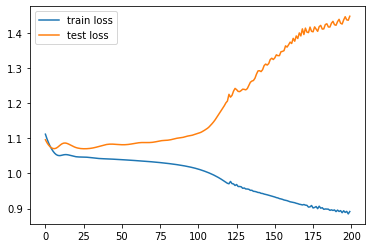

In [43]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [44]:
# One-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1, T, 1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

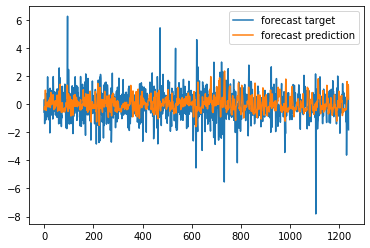

In [45]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [46]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

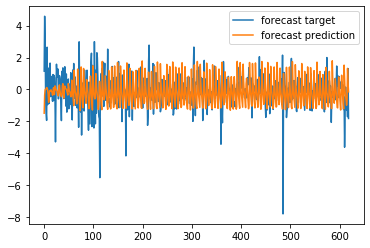

In [47]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# Part 3: Binary Classification

In [7]:
df = pd.read_csv('../../eICU/training/finalData.csv')
df

,patientunitstayid,observationoffset,temperature,heartrate,respiration,systemicsystolic,creatinine,wbcx1000,lactate,urineoutputbyweight,diagnosis
0,143870,7.0,37.132325,44.0,86.0,111.000000,0.89,11.7,2.30671,3.870968,0.0
1,143870,10.0,37.132325,43.0,80.5,112.500000,0.89,11.7,2.30671,3.870968,0.0
2,143870,12.0,37.132325,42.0,75.0,114.000000,0.89,11.7,2.30671,3.870968,0.0
3,143870,17.0,37.132325,41.0,78.0,113.000000,0.89,11.7,2.30671,3.870968,0.0
4,143870,22.0,37.132325,41.0,73.0,113.000000,0.89,11.7,2.30671,3.870968,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1230089,3353113,2671.0,37.132325,87.0,27.0,125.654566,0.57,5.0,1.80000,0.852273,0.0
1230090,3353113,2676.0,37.132325,85.0,27.0,125.654566,0.57,5.0,1.80000,0.852273,0.0
1230091,3353113,2681.0,37.132325,84.0,26.0,125.654566,0.57,5.0,1.80000,0.852273,0.0
1230092,3353113,2686.0,37.132325,84.0,25.0,125.654566,0.57,5.0,1.80000,0.852273,0.0


In [8]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['temperature', 'heartrate', 'respiration', 'systemicsystolic', 'creatinine', 'wbcx1000', 'lactate', 'urineoutputbyweight']].values
targets = df['diagnosis'].values

In [9]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)
D

8

In [10]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [11]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [12]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [13]:
# make the RNN
model = RNN(8, 5, 2, 1)
model.to(device)

RNN(
  (rnn): LSTM(8, 5, num_layers=2, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Loss and optimizer - it's classification now!
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [16]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [30]:
torch.cuda.empty_cache()

In [20]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=1000)

Epoch 5/1000, Train Loss: 0.0159, Test Loss: 0.0161
Epoch 10/1000, Train Loss: 0.0150, Test Loss: 0.0153
Epoch 15/1000, Train Loss: 0.0142, Test Loss: 0.0145
Epoch 20/1000, Train Loss: 0.0135, Test Loss: 0.0138
Epoch 25/1000, Train Loss: 0.0128, Test Loss: 0.0132
Epoch 30/1000, Train Loss: 0.0122, Test Loss: 0.0126
Epoch 35/1000, Train Loss: 0.0117, Test Loss: 0.0121
Epoch 40/1000, Train Loss: 0.0112, Test Loss: 0.0116
Epoch 45/1000, Train Loss: 0.0107, Test Loss: 0.0111
Epoch 50/1000, Train Loss: 0.0103, Test Loss: 0.0107
Epoch 55/1000, Train Loss: 0.0099, Test Loss: 0.0103
Epoch 60/1000, Train Loss: 0.0095, Test Loss: 0.0100
Epoch 65/1000, Train Loss: 0.0092, Test Loss: 0.0096
Epoch 70/1000, Train Loss: 0.0088, Test Loss: 0.0093
Epoch 75/1000, Train Loss: 0.0085, Test Loss: 0.0090
Epoch 80/1000, Train Loss: 0.0082, Test Loss: 0.0087
Epoch 85/1000, Train Loss: 0.0080, Test Loss: 0.0085
Epoch 90/1000, Train Loss: 0.0077, Test Loss: 0.0083
Epoch 95/1000, Train Loss: 0.0075, Test Loss: 0

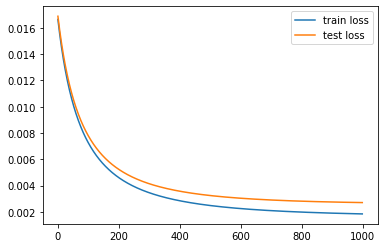

In [21]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [22]:
# Get accuracy
with torch.no_grad():
  p_train = model(X_train)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train.cpu().numpy() == p_train)

  p_test = model(X_test)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9998, Test acc: 0.9997
